# Fig 1 Classifying pain-associated diagnoses using biological and psychosocial modalities

### This notebook contains the code for a secondary analyses for figure 1:
- Calculate and plot the deviance explained for models trained to predict rheumatoid arthritis based on blood, psychosocial, and their union
- Calculate and plot the deviance explained for models trained to predict fibromyalgia based on brain, psychosocial, and their union
- Calculate and plot the deviance explained for models trained to predict chronic pain based on blood/brain, psychosocial, and their union

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from matplotlib_venn import venn2, venn2_circles
warnings.filterwarnings("ignore")

home_dir = '/Users/Patty/Desktop/EVP_lab/'

fs = 7
w = 0.5
sns.set_context(rc={"font.size":fs})   
plt.rcParams['font.size'] = fs
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['figure.dpi'] = 300
plt.rc('mathtext',**{'default':'regular'})
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 2.5
plt.rcParams['ytick.major.size'] = 2.5
plt.rcParams['xtick.major.pad'] = '1.5'
plt.rcParams['ytick.major.pad'] = '1.5'
plt.rcParams['xtick.major.width'] = w
plt.rcParams['ytick.major.width'] = w
plt.rcParams['xtick.minor.size'] = 2.5
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['xtick.minor.pad'] = '1.5'
plt.rcParams['ytick.minor.pad'] = '1.5'
plt.rcParams['xtick.minor.width'] = w
plt.rcParams['ytick.minor.width'] = w
plt.rcParams['axes.linewidth'] = w

sns.set_style("white")
sns.set_context("notebook")

color_mapping = {
 'Blood': '#9EB9F3',
 'Bone': '#F89C74',
 'PRS': '#DCB0F2',
 'Stacked': '#87C55F',
 'Psychosocial': '#C0BFC9'}

In [2]:
pain_T0 = pd.read_pickle('/Users/Patty/Desktop/Biomarker_Paper/Pickled_Models/Pain/T0_pain_clf-LR_lin.pickle')
pain_T2 = pd.read_pickle('/Users/Patty/Desktop/Biomarker_Paper/Pickled_Models/Pain/T2_pain_clf-LR_lin.pickle')

## Calculate deviance explained for CP models based on blood and psychosocial features

In [6]:
blood_cp = pd.DataFrame(np.concatenate([pain_T0[i]['roc_curve'] for i in pain_T0.keys() if 'ChronicPain_Blood' in i],axis=1),index=['eid','CP','prob_blood']).T.groupby('eid').mean()
psych_cp = pd.DataFrame(np.concatenate([pain_T0[i]['roc_curve'] for i in pain_T0.keys() if 'ChronicPain_Psycho' in i],axis=1),index=['eid','CP','prob_psych']).T.groupby('eid').mean()
combined_df = blood_cp.merge(psych_cp,on='eid')
combined_df[['prob_blood','prob_psych']] = np.where(combined_df[['prob_blood','prob_psych']]>0.5,1,0)

B = combined_df[['prob_blood']].values
P = combined_df[['prob_psych']].values
B_P = np.concatenate([B, P], axis=1)
y = combined_df['CP_x'].values

# Fit Models
model_blood = LogisticRegression().fit(B, y)
model_psychosocial = LogisticRegression().fit(P, y)
model_combined = LogisticRegression().fit(B_P, y)

# Compute Log-Likelihoods
loglikelihood_blood = -log_loss(y, model_blood.predict_proba(B), normalize=False)
loglikelihood_psychosocial = -log_loss(y, model_psychosocial.predict_proba(P), normalize=False)
loglikelihood_combined = -log_loss(y, model_combined.predict_proba(B_P), normalize=False)


# Null Model: Logistic regression with only an intercept
null_model = LogisticRegression().fit(np.ones((y.shape[0], 1)), y)
loglikelihood_null = -log_loss(y, null_model.predict_proba(np.ones((y.shape[0], 1))), normalize=False)

# Saturated Model Log-Likelihood
# In logistic regression, log-likelihood of the saturated model is 0
loglikelihood_saturated = 1

# Compute Deviance for Each Model
deviance_blood = 2 * (loglikelihood_saturated - loglikelihood_blood)
deviance_psychosocial = 2 * (loglikelihood_saturated - loglikelihood_psychosocial)
deviance_combined = 2 * (loglikelihood_saturated - loglikelihood_combined)
deviance_null = 2 * (loglikelihood_saturated - loglikelihood_null)

# Compute D^2 for each model
D2_blood = 1 - (deviance_blood / deviance_null)
D2_psychosocial = 1 - (deviance_psychosocial / deviance_null)
D2_combined = 1 - (deviance_combined / deviance_null)

# Results
print("D2 Blood Data:", D2_blood)
print("D2 Psychosocial Data:", D2_psychosocial)
print("D2 Combined Data:", D2_combined)

# Decompose the explained deviance
delta_D2_p = D2_combined - D2_blood  # Unique deviance explained by psychosocial data
delta_D2_b = D2_combined - D2_psychosocial  # Unique deviance explained by blood data
D2_intersect = D2_combined - delta_D2_b - delta_D2_p  # Intersection of blood and psychosocial data

# Results
print("Delta D2 (Psychosocial Data):", delta_D2_p)
print("Delta D2 (Blood Data):", delta_D2_b)
print("D2 Intersection:", D2_intersect)

D2 Blood Data: 0.01235648469443651
D2 Psychosocial Data: 0.062268104846107564
D2 Combined Data: 0.06710510703693728
Delta D2 (Psychosocial Data): 0.054748622342500775
Delta D2 (Blood Data): 0.00483700219082972
D2 Intersection: 0.007519482503606789


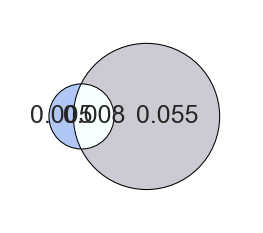

In [608]:
fig, axs = plt.subplots(figsize=(.85,.85))
# sns.set_style("white")

# Values for the Venn diagram
delta_d2_psychosocial = delta_D2_p
delta_d2_blood = delta_D2_b
d2_intersection = D2_intersect

# The actual sizes for Venn diagram areas should be proportional to the values
# Since Venn diagram circles areas (not radii) are used to show the size, we use sqrt to simulate the area representation
psychosocial_size = np.sqrt(delta_d2_psychosocial)
blood_size = np.sqrt(delta_d2_blood)
intersection_size = np.sqrt(d2_intersection)

psychosocial_size = delta_d2_psychosocial
blood_size = delta_d2_blood
intersection_size = d2_intersection

# Calculate the sizes for the Venn diagram
# Venn2 requires the sizes of the two circles and their intersection
venn_sizes = (blood_size, psychosocial_size, intersection_size)

font = 7
v = venn2(ax=axs, subsets = venn_sizes, set_labels = ('',''), set_colors=('#9EB9F3', '#C0BFC9'), alpha=0.8) #.get_patch_by_id('111').set_color('grey')
c = venn2_circles(ax=axs, subsets = venn_sizes, linewidth=.25, color = 'k')

# Manually set the labels to the original values
v.get_label_by_id('10').set_text(f"{delta_d2_blood:.3f}")
v.get_label_by_id('01').set_text(f"{delta_d2_psychosocial:.3f}")
v.get_label_by_id('11').set_text(f"{d2_intersection:.3f}")

for text in v.set_labels:
    text.set_fontsize(6)
for text in v.subset_labels:
    text.set_fontsize(6)

fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_2_Diagnoses/CP_blood_venn.pdf", 
        transparent=True,dpi=300,bbox_inches='tight')

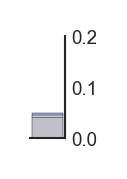

In [733]:
def plot_stacked_bar_simple(deviances, labels, colors):
    """
    Plot a simple stacked bar chart of deviance explained without labels, title, and legend.

    :param deviances: List of deviance values for each component.
    :param labels: List of labels for each component.
    :param colors: List of colors for each component.
    """
    if len(deviances) != len(labels) or len(labels) != len(colors):
        raise ValueError("The length of deviances, labels, and colors must be the same.")

    # Create stacked bar plot
    fig,ax = plt.subplots(figsize=(.15, .45))
    bottom = 0
    for deviance, color in zip(deviances, colors):
        ax.bar([''], deviance, bottom=bottom, color=color, edgecolor='k', linewidth=.1)
        bottom += deviance

    # Show plot
    sns.despine(left=True,bottom=False,right=False)
    ax.yaxis.tick_right()  # Move y-axis ticks to the right
    ax.set_ylim(0,.2)
    plt.xticks([], [])
    for spine in ax.spines.values():
        spine.set_linewidth(.5) 
    ax.tick_params(axis='both', which='both',labelsize=4.5,length=0)
    plt.show()
    
    
    fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_2_Diagnoses/bar_CP_blood.pdf", 
            transparent=True,dpi=300,bbox_inches='tight')

# Example usage
deviances = [delta_D2_p, D2_intersect, delta_D2_b]
colors = ['#C0BFC9', '#F7FFFF', '#9EB9F3']

plot_stacked_bar_simple(deviances, labels, colors)

## Calculate deviance explained for CP models based on brain and psychosocial features

In [20]:
brain_cp = pd.DataFrame(np.concatenate([pain_T2[i]['roc_curve'] for i in pain_T2.keys() if 'ChronicPain_Stacked' in i],axis=1),index=['eid','CP','prob_brain']).T.groupby('eid').mean()
psych_cp = pd.DataFrame(np.concatenate([pain_T2[i]['roc_curve'] for i in pain_T2.keys() if 'ChronicPain_Psycho' in i],axis=1),index=['eid','CP','prob_psych']).T.groupby('eid').mean()
combined_df = brain_cp.merge(psych_cp,on='eid')
combined_df[['prob_brain','prob_psych']] = np.where(combined_df[['prob_brain','prob_psych']]>0.5,1,0)

combined_df = pd.concat([combined_df[combined_df['CP_x'] == 1],combined_df[combined_df['CP_x'] == 0].sample(int(combined_df.CP_x.sum()))])
    
B = combined_df[['prob_brain']].values
P = combined_df[['prob_psych']].values
B_P = np.concatenate([B, P], axis=1)
y = combined_df['CP_x'].values

# Fit Models
model_brain = LogisticRegression().fit(B, y)
model_psychosocial = LogisticRegression().fit(P, y)
model_combined = LogisticRegression().fit(B_P, y)

# Compute Log-Likelihoods
loglikelihood_brain = -log_loss(y, model_brain.predict_proba(B), normalize=False)
loglikelihood_psychosocial = -log_loss(y, model_psychosocial.predict_proba(P), normalize=False)
loglikelihood_combined = -log_loss(y, model_combined.predict_proba(B_P), normalize=False)


# Null Model: Logistic regression with only an intercept
null_model = LogisticRegression().fit(np.ones((y.shape[0], 1)), y)
loglikelihood_null = -log_loss(y, null_model.predict_proba(np.ones((y.shape[0], 1))), normalize=False)

# Saturated Model Log-Likelihood
# In logistic regression, log-likelihood of the saturated model is 0
loglikelihood_saturated = 1

# Compute Deviance for Each Model
deviance_brain = 2 * (loglikelihood_saturated - loglikelihood_brain)
deviance_psychosocial = 2 * (loglikelihood_saturated - loglikelihood_psychosocial)
deviance_combined = 2 * (loglikelihood_saturated - loglikelihood_combined)
deviance_null = 2 * (loglikelihood_saturated - loglikelihood_null)

# Compute D^2 for each model
D2_brain = 1 - (deviance_brain / deviance_null)
D2_psychosocial = 1 - (deviance_psychosocial / deviance_null)
D2_combined = 1 - (deviance_combined / deviance_null)

# Results
print("D2 Brain Data:", D2_brain)
print("D2 Psychosocial Data:", D2_psychosocial)
print("D2 Combined Data:", D2_combined)

# Decompose the explained deviance
delta_D2_p = D2_combined - D2_brain  # Unique deviance explained by psychosocial data
delta_D2_b = D2_combined - D2_psychosocial  # Unique deviance explained by brain data
D2_intersect = D2_combined - delta_D2_b - delta_D2_p  # Intersection of brain and psychosocial data

# Results
print("Delta D2 (Psychosocial Data):", delta_D2_p)
print("Delta D2 (Brain Data):", delta_D2_b)
print("D2 Intersection:", D2_intersect)

D2 Brain Data: 0.006411491907555744
D2 Psychosocial Data: 0.043789216721218716
D2 Combined Data: 0.048225288061922944
Delta D2 (Psychosocial Data): 0.0418137961543672
Delta D2 (Brain Data): 0.0044360713407042285
D2 Intersection: 0.0019754205668515157


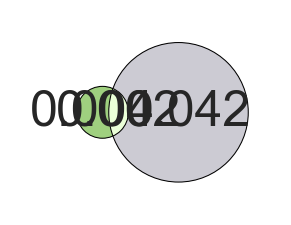

In [611]:
fig, axs = plt.subplots(figsize=(.85,.85))
# sns.set_style("white")

# Values for the Venn diagram
delta_d2_psychosocial = delta_D2_p
delta_d2_brain = delta_D2_b
d2_intersection = D2_intersect

# The actual sizes for Venn diagram areas should be proportional to the values
# Since Venn diagram circles areas (not radii) are used to show the size, we use sqrt to simulate the area representation
psychosocial_size = np.sqrt(delta_d2_psychosocial)
brain_size = np.sqrt(delta_d2_brain)
intersection_size = np.sqrt(d2_intersection)

psychosocial_size = delta_d2_psychosocial
brain_size = delta_d2_brain
intersection_size = d2_intersection

# Calculate the sizes for the Venn diagram
# Venn2 requires the sizes of the two circles and their intersection
venn_sizes = (brain_size, psychosocial_size, intersection_size)

font = 7
v = venn2(ax=axs, subsets = venn_sizes, set_labels = ('',''), set_colors=('#87C55F', '#C0BFC9'), alpha=0.8) #.get_patch_by_id('111').set_color('grey')
c = venn2_circles(ax=axs, subsets = venn_sizes, linewidth=.25, color = 'k')

# Manually set the labels to the original values
v.get_label_by_id('10').set_text(f"{delta_d2_brain:.3f}")
v.get_label_by_id('01').set_text(f"{delta_d2_psychosocial:.3f}")
v.get_label_by_id('11').set_text(f"{d2_intersection:.3f}")
    
axs.set_title('', fontdict={'fontsize': font})
for text in v.set_labels: 
    text.set_fontsize(font)

fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_2_Diagnoses/CP_brain_venn.pdf", 
        transparent=True,dpi=300,bbox_inches='tight')

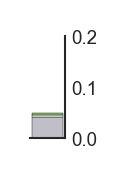

In [732]:
def plot_stacked_bar_simple(deviances, labels, colors):
    """
    Plot a simple stacked bar chart of deviance explained without labels, title, and legend.

    :param deviances: List of deviance values for each component.
    :param labels: List of labels for each component.
    :param colors: List of colors for each component.
    """
    if len(deviances) != len(labels) or len(labels) != len(colors):
        raise ValueError("The length of deviances, labels, and colors must be the same.")

    # Create stacked bar plot
    fig,ax = plt.subplots(figsize=(.15, .45))
    bottom = 0
    for deviance, color in zip(deviances, colors):
        ax.bar([''], deviance, bottom=bottom, color=color, edgecolor='k', linewidth=.1)
        bottom += deviance

    # Show plot
    sns.despine(left=True,bottom=False,right=False)
    ax.yaxis.tick_right()  # Move y-axis ticks to the right
    ax.set_ylim(0,.2)
    plt.xticks([], [])
    for spine in ax.spines.values():
        spine.set_linewidth(.5) 
    ax.tick_params(axis='both', which='both',labelsize=4.5,length=0)
    plt.show()
    
    
    fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_2_Diagnoses/bar_CP_brain.pdf", 
            transparent=True,dpi=300,bbox_inches='tight')

# Example usage
deviances = [delta_D2_p, D2_intersect, delta_D2_b]
colors = ['#C0BFC9', '#F7FFFF', '#87C55F']
plot_stacked_bar_simple(deviances, labels, colors)

## Calculate deviance explained for rheumatoid arthritis model based on blood and psychosocial features

In [21]:
t0 = pd.read_pickle('/Users/Patty/Desktop/Biomarker_Paper/Pickled_Models/Diagnoses/Deviance/Deviance_T0_diagnoses_clf-LR_lin.pickle')


In [22]:
dx = 'rheumatoid arthritis'
B = np.where(np.concatenate([t0[i]['roc_curve'][2] for i in t0.keys() if f'{dx}_Blood_onl' in i]) > 0.5, 1, 0).reshape(-1, 1)
P = np.where(np.concatenate([t0[i]['roc_curve'][2] for i in t0.keys() if f'{dx}_Psychosoci' in i]) > 0.5, 1, 0).reshape(-1, 1)
B_P = np.concatenate([B, P], axis=1)
# B_P = np.where(np.concatenate([t0[i]['roc_curve'][2] for i in t0.keys() if f'{dx}_Blood_Psych' in i]) > 0.5, 1, 0).reshape(-1, 1)
y = np.concatenate([t0[i]['roc_curve'][1] for i in t0.keys() if f'{dx}_Blood_onl' in i]).reshape(-1, 1)

# Fit Models
model_blood = LogisticRegression().fit(B, y)
model_psychosocial = LogisticRegression().fit(P, y)
model_combined = LogisticRegression().fit(B_P, y)

# Compute Log-Likelihoods
loglikelihood_blood = -log_loss(y, model_blood.predict_proba(B), normalize=False)
loglikelihood_psychosocial = -log_loss(y, model_psychosocial.predict_proba(P), normalize=False)
loglikelihood_combined = -log_loss(y, model_combined.predict_proba(B_P), normalize=False)


# Null Model: Logistic regression with only an intercept
null_model = LogisticRegression().fit(np.ones((y.shape[0], 1)), y)
loglikelihood_null = -log_loss(y, null_model.predict_proba(np.ones((y.shape[0], 1))), normalize=False)

# Saturated Model Log-Likelihood
# In logistic regression, log-likelihood of the saturated model is 0
loglikelihood_saturated = 1

# Compute Deviance for Each Model
deviance_blood = 2 * (loglikelihood_saturated - loglikelihood_blood)
deviance_psychosocial = 2 * (loglikelihood_saturated - loglikelihood_psychosocial)
deviance_combined = 2 * (loglikelihood_saturated - loglikelihood_combined)
deviance_null = 2 * (loglikelihood_saturated - loglikelihood_null)

# Compute D^2 for each model
D2_blood = 1 - (deviance_blood / deviance_null)
D2_psychosocial = 1 - (deviance_psychosocial / deviance_null)
D2_combined = 1 - (deviance_combined / deviance_null)

# Results
print("D2 Blood Data:", D2_blood)
print("D2 Psychosocial Data:", D2_psychosocial)
print("D2 Combined Data:", D2_combined)

# Decompose the explained deviance
delta_D2_p = D2_combined - D2_blood  # Unique deviance explained by psychosocial data
delta_D2_b = D2_combined - D2_psychosocial  # Unique deviance explained by blood data
D2_intersect = D2_combined - delta_D2_b - delta_D2_p  # Intersection of blood and psychosocial data

# Results
print("Delta D2 (Psychosocial Data):", delta_D2_p)
print("Delta D2 (Blood Data):", delta_D2_b)
print("D2 Intersection:", D2_intersect)


D2 Blood Data: 0.12736919324774987
D2 Psychosocial Data: 0.10906052568253899
D2 Combined Data: 0.1851388664356225
Delta D2 (Psychosocial Data): 0.05776967318787263
Delta D2 (Blood Data): 0.0760783407530835
D2 Intersection: 0.05129085249466636


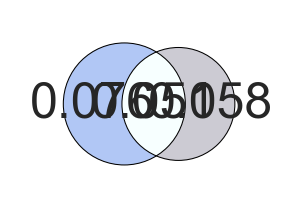

In [23]:
fig, axs = plt.subplots(figsize=(.85,.85))
# sns.set_style("white")

# Values for the Venn diagram
delta_d2_psychosocial = delta_D2_p
delta_d2_blood = delta_D2_b
d2_intersection = D2_intersect

# The actual sizes for Venn diagram areas should be proportional to the values
# Since Venn diagram circles areas (not radii) are used to show the size, we use sqrt to simulate the area representation
psychosocial_size = np.sqrt(delta_d2_psychosocial)
blood_size = np.sqrt(delta_d2_blood)
intersection_size = np.sqrt(d2_intersection)

psychosocial_size = delta_d2_psychosocial
blood_size = delta_d2_blood
intersection_size = d2_intersection

# Calculate the sizes for the Venn diagram
# Venn2 requires the sizes of the two circles and their intersection
venn_sizes = (blood_size, psychosocial_size, intersection_size)

font = 7
v = venn2(ax=axs, subsets = venn_sizes, set_labels = ('',''), set_colors=('#9EB9F3', '#C0BFC9'), alpha=0.8) #.get_patch_by_id('111').set_color('grey')
c = venn2_circles(ax=axs, subsets = venn_sizes, linewidth=.25, color = 'k')

# Manually set the labels to the original values
v.get_label_by_id('10').set_text(f"{delta_d2_blood:.3f}")
v.get_label_by_id('01').set_text(f"{delta_d2_psychosocial:.3f}")
v.get_label_by_id('11').set_text(f"{d2_intersection:.3f}")
    
axs.set_title('', fontdict={'fontsize': font})
for text in v.set_labels: 
    text.set_fontsize(font)

fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_2_Diagnoses/RA_venn.pdf", 
        transparent=True,dpi=300,bbox_inches='tight')

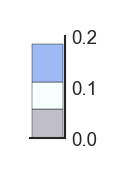

In [726]:
def plot_stacked_bar_simple(deviances, labels, colors):
    """
    Plot a simple stacked bar chart of deviance explained without labels, title, and legend.

    :param deviances: List of deviance values for each component.
    :param labels: List of labels for each component.
    :param colors: List of colors for each component.
    """
    if len(deviances) != len(labels) or len(labels) != len(colors):
        raise ValueError("The length of deviances, labels, and colors must be the same.")

    # Create stacked bar plot
    fig,ax = plt.subplots(figsize=(.15, .45))
    bottom = 0
    for deviance, color in zip(deviances, colors):
        ax.bar([''], deviance, bottom=bottom, color=color, edgecolor='k', linewidth=.1)
        bottom += deviance

    # Show plot
    sns.despine(left=True,bottom=False,right=False)
    ax.yaxis.tick_right()  # Move y-axis ticks to the right
    ax.set_ylim(0,.2)
    plt.xticks([], [])
    for spine in ax.spines.values():
        spine.set_linewidth(.5) 
    ax.tick_params(axis='both', which='both',labelsize=4.5,length=0)
    plt.show()
    
    
    fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_2_Diagnoses/bar_RA.pdf", 
            transparent=True,dpi=300,bbox_inches='tight')

# Example usage
deviances = [delta_D2_p, D2_intersect, delta_D2_b]
colors = ['#C0BFC9', '#F7FFFF', '#9EB9F3']
plot_stacked_bar_simple(deviances, labels, colors)

## Calculate deviance explained for fibromyalgia model based on brain and psychosocial features

In [24]:
t2 = pd.read_pickle('/Users/Patty/Desktop/Biomarker_Paper/Pickled_Models/Diagnoses/Deviance/Deviance_T2_diagnoses_clf-LR_lin.pickle')

In [727]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import pandas as pd

dx = 'fibromyalgia'

brain_l = []
psych_l = []
comb_l = []

for i in range(500): # Iterate through 
    Br = np.where(np.concatenate([t2[i]['roc_curve'][2] for i in t2.keys() if f'{dx}_Stacked' in i]) > 0.5, 1, 0).reshape(-1, 1)
    P = np.where(np.concatenate([t2[i]['roc_curve'][2] for i in t2.keys() if f'{dx}_Psychosocial' in i]) > 0.5, 1, 0).reshape(-1, 1)
    combined_data = np.concatenate([Br, P], axis=1)

    y = np.concatenate([t2[i]['roc_curve'][1] for i in t2.keys() if f'{dx}_Bone' in i]).reshape(-1, 1)

    tmp = pd.DataFrame(np.concatenate([combined_data,y],axis=1),columns=['Br','P','y'])
    tmp = pd.concat([tmp[tmp['y'] == 1],tmp[tmp['y'] == 0].sample(int(y.sum()))])

    Br = tmp[['Br']]
    P = tmp[['P']]
    combined_data = tmp[['Br', 'P']].values
    y = tmp[['y']]

    # Bone, brain, genetic, and psychosocial data are B, Br, G, and P respectively

    # Fit logistic regression models for each data set
    model_brain = LogisticRegression().fit(Br, y)
    model_psychosocial = LogisticRegression().fit(P, y)
    # Fit a combined model with all datasets
    model_combined = LogisticRegression().fit(combined_data, y)

    # Calculate log-likelihoods for each model
    loglikelihood_brain = -log_loss(y, model_brain.predict_proba(Br), normalize=False)
    loglikelihood_psychosocial = -log_loss(y, model_psychosocial.predict_proba(P), normalize=False)
    loglikelihood_combined = -log_loss(y, model_combined.predict_proba(combined_data)[:,1], normalize=False)

    # Null Model
    null_model = LogisticRegression().fit(np.ones((y.shape[0], 1)), y)
    loglikelihood_null = -log_loss(y, null_model.predict_proba(np.ones((y.shape[0], 1))), normalize=False)

    # Calculate deviances
    deviance_null = -2 * loglikelihood_null
    deviance_brain = -2 * loglikelihood_brain
    deviance_psychosocial = -2 * loglikelihood_psychosocial
    deviance_combined = -2 * loglikelihood_combined

    # Calculate D^2 for each model
    D2_brain = 1 - (deviance_brain / deviance_null)
    D2_psychosocial = 1 - (deviance_psychosocial / deviance_null)
    D2_combined = 1 - (deviance_combined / deviance_null)
    
    brain_l.append(D2_brain)
    psych_l.append(D2_psychosocial)
    comb_l.append(D2_combined)

D2_brain = np.mean(brain_l)                  
D2_psychosocial = np.mean(psych_l)                  
D2_combined = np.mean(comb_l)   
                  
# Print results
print("Explained Deviance (Brain Data):", D2_brain)
print("Explained Deviance (Psychosocial Data):", D2_psychosocial)
print("Explained Deviance (Combined Model):", D2_combined)

# Decompose the explained deviance
delta_D2_p = D2_combined - D2_brain  # Unique deviance explained by psychosocial data
delta_D2_b = D2_combined - D2_psychosocial  # Unique deviance explained by blood data
D2_intersect = D2_combined - delta_D2_b - delta_D2_p  # Intersection of blood and psychosocial data

# Results
print("Delta D2 (Psychosocial Data):", delta_D2_p)
print("Delta D2 (Brain Data):", delta_D2_b)
print("D2 Intersection:", D2_intersect)

Explained Deviance (Brain Data): 0.05096721041536438
Explained Deviance (Psychosocial Data): 0.14611688244088772
Explained Deviance (Combined Model): 0.1964733975997424
Delta D2 (Psychosocial Data): 0.14550618718437802
Delta D2 (Brain Data): 0.05035651515885467
D2 Intersection: 0.0006106952565096968


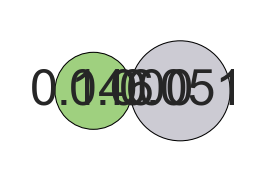

In [46]:
fig, axs = plt.subplots(figsize=(.85,.85))
# sns.set_style("white")

# Values for the Venn diagram
delta_d2_psychosocial = delta_D2_p
delta_d2_brain = delta_D2_b
d2_intersection = 0.000001 # Intersection is negligible so setting to very small number for plotting

# The actual sizes for Venn diagram areas should be proportional to the values
# Since Venn diagram circles areas (not radii) are used to show the size, we use sqrt to simulate the area representation
psychosocial_size = np.sqrt(delta_d2_psychosocial)
brain_size = np.sqrt(delta_d2_brain)
intersection_size = np.sqrt(d2_intersection)

# Calculate the sizes for the Venn diagram
# Venn2 requires the sizes of the two circles and their intersection
venn_sizes = (brain_size, psychosocial_size, intersection_size)

font = 6
v = venn2(ax=axs, subsets = venn_sizes, set_labels = ('', ''), set_colors=('#87C55F', '#C0BFC9'), alpha=0.8) #.get_patch_by_id('111').set_color('grey')
c = venn2_circles(ax=axs, subsets = venn_sizes, linewidth=.25, color = 'k')

# Manually set the labels to the original values
v.get_label_by_id('10').set_text(f"{delta_d2_psychosocial:.3f}")
v.get_label_by_id('01').set_text(f"{delta_d2_brain:.3f}")
v.get_label_by_id('11').set_text(f"{d2_intersection:.3f}")
    
axs.set_title('', fontdict={'fontsize': font})
for text in v.set_labels: 
    text.set_fontsize(font)

fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_2_Diagnoses/fibro_venn.pdf", 
        transparent=True,dpi=300,bbox_inches='tight')

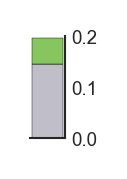

In [729]:
def plot_stacked_bar_simple(deviances, labels, colors):
    """
    Plot a simple stacked bar chart of deviance explained without labels, title, and legend.

    :param deviances: List of deviance values for each component.
    :param labels: List of labels for each component.
    :param colors: List of colors for each component.
    """
    if len(deviances) != len(labels) or len(labels) != len(colors):
        raise ValueError("The length of deviances, labels, and colors must be the same.")

    # Create stacked bar plot
    fig,ax = plt.subplots(figsize=(.15, .45))
    bottom = 0
    for deviance, color in zip(deviances, colors):
        ax.bar([''], deviance, bottom=bottom, color=color, edgecolor='k', linewidth=.1)
        bottom += deviance

    # Show plot
    sns.despine(left=True,bottom=False,right=False)
    ax.yaxis.tick_right()  # Move y-axis ticks to the right
    ax.set_ylim(0,.2)
    plt.xticks([], [])
    for spine in ax.spines.values():
        spine.set_linewidth(.5) 
    ax.tick_params(axis='both', which='both',labelsize=4.5,length=0)
    plt.show()
    
    
    fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_2_Diagnoses/bar_fibro.pdf", 
            transparent=True,dpi=300,bbox_inches='tight')

# Example usage
deviances = [delta_D2_p, D2_intersect, delta_D2_b]
colors = ['#C0BFC9', '#F7FFFF', '#87C55F']
plot_stacked_bar_simple(deviances, labels, colors)